In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from patsy import dmatrices
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
from matplotlib.pyplot import legend, figure

### Here you will find: 

- Initial data summary
- Multivariable linear regression assumption test.
- Feature Importance
- MMM with daily data
- MMM with Weekly data.
- Log-log model.

## Data Summary

In [34]:
# Load the model data
df = pd.read_csv('AMMMTable.csv',dtype={
    'Revenue': np.float64,
    'Facebook BA': np.float64,
    'Facebook SA': np.float64,
    'Google': np.float64,
    'Microsoft': np.float64,
    'Pin BW': np.float64,
}, parse_dates=['Date'])
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Year_Month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)
df['WeekNumber'] = pd.DatetimeIndex(df['Date']).week
df.head()

/var/folders/k2/8mbjx2mx4jg3bkxxj6m1xbs40000gn/T/ipykernel_17377/1206350869.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['WeekNumber'] = pd.DatetimeIndex(df['Date']).week


,Date,Facebook BA,Facebook SA,Google,Microsoft,Pin BW,Revenue,Year,Month,Year_Month,WeekNumber
0,2019-04-20,49.76,16.55,734.64,NaN,NaN,12239.69,2019,4,2019-4,16
1,2019-04-21,45.63,16.54,797.93,NaN,NaN,5775.28,2019,4,2019-4,16
2,2019-04-22,47.32,16.61,1153.88,NaN,NaN,12114.80,2019,4,2019-4,17
3,2019-04-23,47.64,16.54,837.82,NaN,NaN,13504.72,2019,4,2019-4,17
4,2019-04-24,47.89,16.89,822.67,NaN,NaN,8179.32,2019,4,2019-4,17


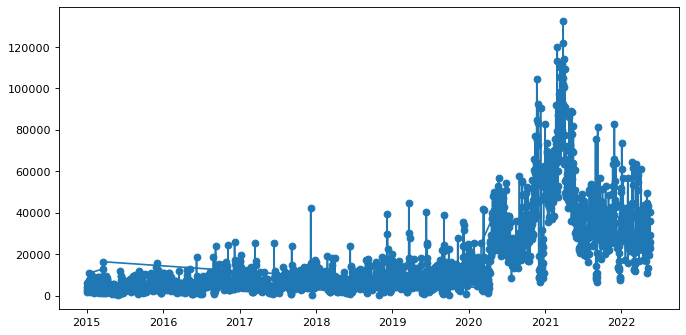

In [35]:
figure(figsize=(10, 5), dpi=80)
plt.plot(df['Date'], df['Revenue'], marker='o')
plt.show()

## Data Quality and Analysis

### NaN Values

In [37]:
df[df != 0.0].drop('Year_Month', 1).isna().groupby(df.Year_Month, sort=False).sum().reset_index()

/var/folders/k2/8mbjx2mx4jg3bkxxj6m1xbs40000gn/T/ipykernel_17377/742069122.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df[df != 0.0].drop('Year_Month', 1).isna().groupby(df.Year_Month, sort=False).sum().reset_index()


,Year_Month,Date,Facebook BA,Facebook SA,Google,Microsoft,Pin BW,Revenue,Year,Month,WeekNumber
0,2019-4,0,19,19,0,30,30,0,0,0,0
1,2019-5,0,4,0,0,19,31,0,0,0,0
2,2019-6,0,0,0,0,0,30,0,0,0,0
3,2019-7,0,0,0,0,0,31,0,0,0,0
4,2019-8,0,0,0,0,0,31,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
84,2019-3,0,31,31,0,31,31,0,0,0,0
85,2015-3,0,31,31,31,31,31,0,0,0,0
86,2015-1,0,31,31,31,31,31,0,0,0,0
87,2015-4,0,30,30,30,30,30,0,0,0,0


Periods without investment are noraml (after conversation with client) and correct treatment will be just set it to zero (without imputation)

In [38]:
df = df.fillna(0)
df.head()

,Date,Facebook BA,Facebook SA,Google,Microsoft,Pin BW,Revenue,Year,Month,Year_Month,WeekNumber
0,2019-04-20,49.76,16.55,734.64,0.0,0.0,12239.69,2019,4,2019-4,16
1,2019-04-21,45.63,16.54,797.93,0.0,0.0,5775.28,2019,4,2019-4,16
2,2019-04-22,47.32,16.61,1153.88,0.0,0.0,12114.80,2019,4,2019-4,17
3,2019-04-23,47.64,16.54,837.82,0.0,0.0,13504.72,2019,4,2019-4,17
4,2019-04-24,47.89,16.89,822.67,0.0,0.0,8179.32,2019,4,2019-4,17


### Revenue Behaviour

In [39]:
df[['Revenue', 'Year']].groupby('Year').describe()

Revenue                                                              \
       count          mean           std      min         25%        50%   
Year                                                                       
2015   365.0   4513.716795   2519.314962   385.60   2823.7200   4017.530   
2016   366.0   5905.797541   3748.253621     0.00   3400.2425   5175.115   
2017   365.0   6801.879973   4162.295045   465.21   4246.8800   6117.530   
2018   365.0   7141.001123   4444.602235     0.00   4103.5000   6540.390   
2019   365.0   9352.954301   6028.602173     7.94   5928.4000   8161.410   
2020   366.0  27274.180492  17025.566652  1246.18  14040.7450  24401.485   
2021   365.0  46492.223315  22350.321814  6541.16  30642.5700  42135.890   
2022   140.0  33186.417071  12428.052169     0.00  25035.7800  32090.880   

                             
             75%        max  
Year                         
2015   5580.8000   16307.64  
2016   7424.8875   25849.05  
2017   8388.6200   42209.28  
2018   8804.8700   39445.79  
2019  11080.5800   44542.86  
2020  36378.7725  104311.53  
2021  56838.5100  132478.91  
2022  39736.3400   73789.41

In [40]:
df[['Revenue', 'Year']].groupby('Year').agg(['sum'])

,Revenue
,sum
Year,
2015,1647506.63
2016,2161521.90
2017,2482686.19
2018,2606465.41
2019,3413828.32
2020,9982350.06
2021,16969661.51
2022,4646098.39


<AxesSubplot:title={'center':'Revenue'}, xlabel='[Year]'>

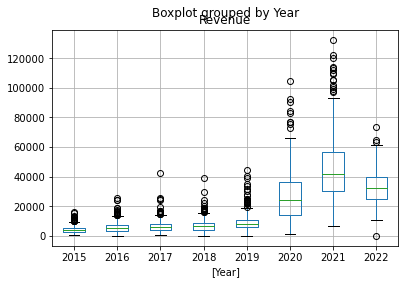

In [41]:
df[['Revenue', 'Year']].boxplot(by='Year')

/var/folders/k2/8mbjx2mx4jg3bkxxj6m1xbs40000gn/T/ipykernel_17377/227019154.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


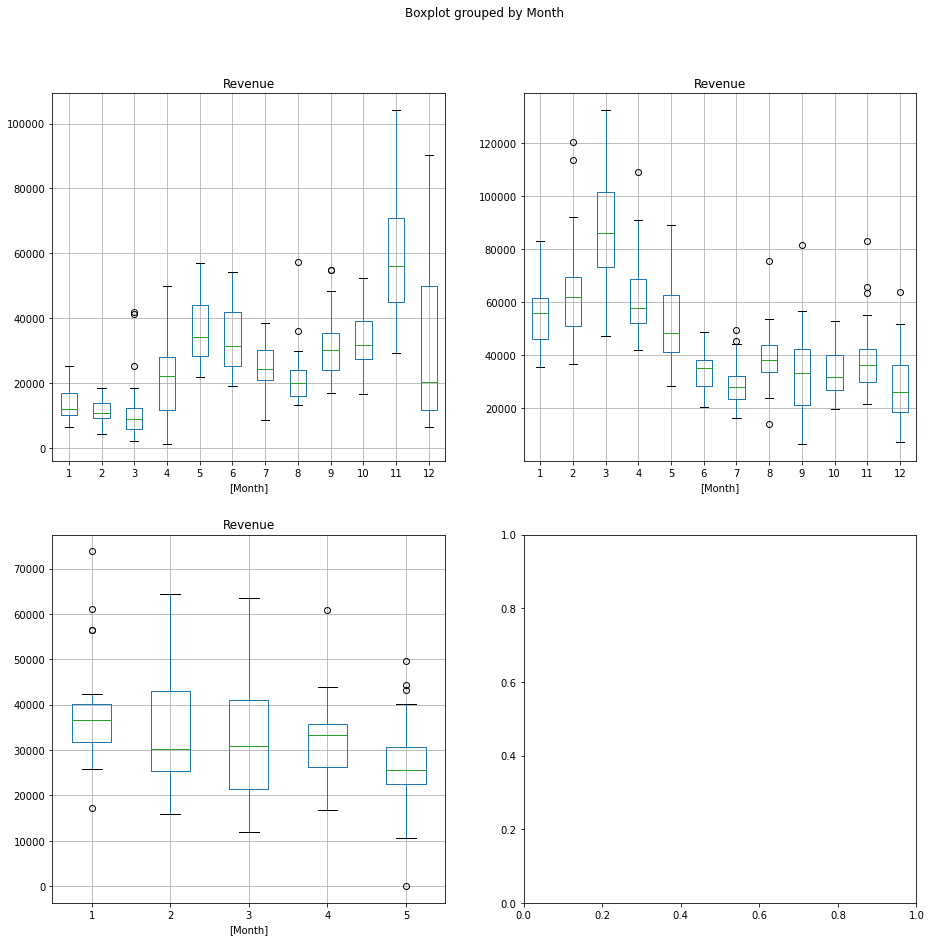

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(15.,15.))


ax = df[df['Year']==2020][['Revenue', 'Month']].boxplot(by='Month', ax=axes[0, 0])
ax = df[df['Year']==2021][['Revenue', 'Month']].boxplot(by='Month', ax=axes[0, 1])
ax = df[df['Year']==2022][['Revenue', 'Month']].boxplot(by='Month', ax=axes[1, 0])
fig.show()

Conclusion

* 2019 Investment into marketing channels began at the end of the year
* 2020 because of covid has a lot of nuisance variables that we cannot account for
* 2022 we don't have enough data.
* 2020 there are several periods without channel investment (probably because of COVID)

Focus the analysis on 2021 data for now and see how later how the model holds in other periods

### From this point forward just information from 2021 will be described

We are accounting for too few variables in the MMM model. By using 2021 data only, we want to reduce the risk of observation external behavior not related to variables that we can measure/control.

In [43]:
df_2021=df[df['Year']==2021].sort_values("Date").reset_index(drop=True)
df_2021.head()

,Date,Facebook BA,Facebook SA,Google,Microsoft,Pin BW,Revenue,Year,Month,Year_Month,WeekNumber
0,2021-01-01,464.08,824.16,4476.01,146.36,57.498894,82921.55,2021,1,2021-1,53
1,2021-01-02,457.15,817.14,5363.22,118.49,66.581756,60075.61,2021,1,2021-1,53
2,2021-01-03,451.77,790.38,5228.40,143.98,85.236258,56313.61,2021,1,2021-1,53
3,2021-01-04,457.18,778.30,3380.94,127.84,71.762240,49477.05,2021,1,2021-1,1
4,2021-01-05,397.81,812.72,2908.67,144.15,81.187551,47978.61,2021,1,2021-1,1


## Channel Investment Behaviour

In [44]:
df_2021[["Facebook BA","Facebook SA","Google","Microsoft", "Pin BW"]].agg(['sum'])


,Facebook BA,Facebook SA,Google,Microsoft,Pin BW
sum,121956.41,241550.61,1126437.98,59333.62,135643.556247


array([[<AxesSubplot:title={'center':'Facebook BA'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Facebook SA'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'Google'}, xlabel='Month'>,
        <AxesSubplot:title={'center':'Microsoft'}, xlabel='Month'>],
       [<AxesSubplot:title={'center':'Pin BW'}, xlabel='Month'>,
        <AxesSubplot:>]], dtype=object)

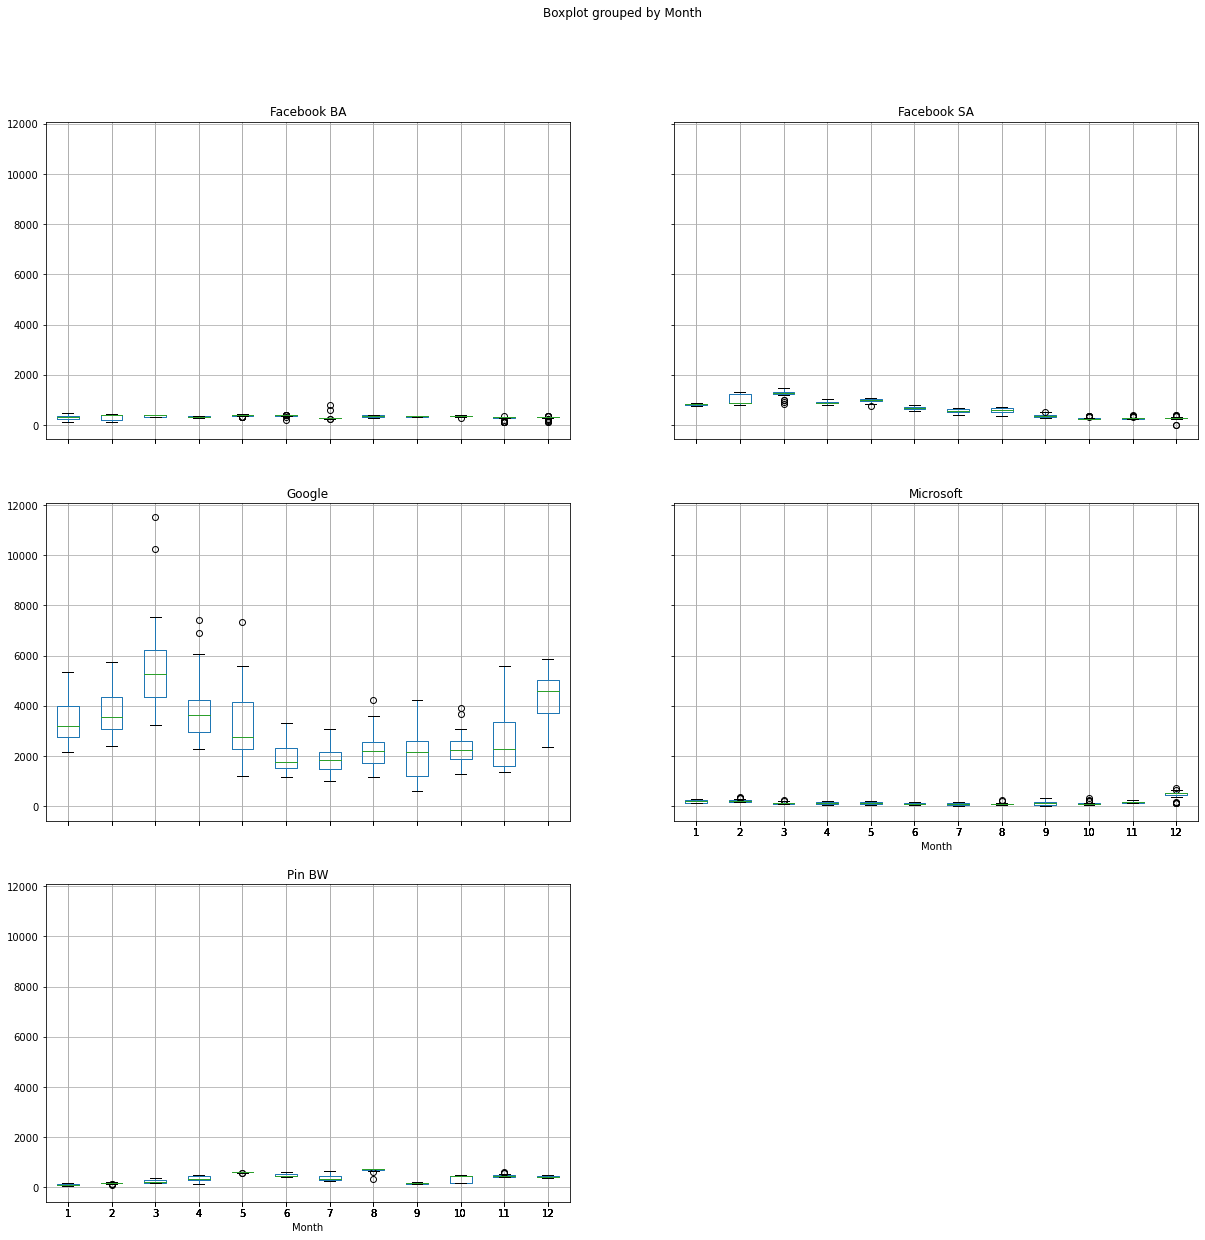

In [45]:
df_2021.boxplot(figsize=(20., 20.), by="Month", column=["Facebook BA","Facebook SA","Google","Microsoft", "Pin BW"])


### Variable Correlations

In [46]:
corr = df_2021[["Facebook BA","Facebook SA","Google","Microsoft", "Pin BW"]].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/k2/8mbjx2mx4jg3bkxxj6m1xbs40000gn/T/ipykernel_17377/2453748810.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Facebook BA,Facebook SA,Google,Microsoft,Pin BW
Facebook BA,1.00,0.28,-0.02,-0.26,0.05
Facebook SA,0.28,1.00,0.45,-0.22,-0.16
Google,-0.02,0.45,1.00,0.39,-0.19
Microsoft,-0.26,-0.22,0.39,1.00,-0.09
Pin BW,0.05,-0.16,-0.19,-0.09,1.00


We are doing this PCA analysis to show how bad the natural aggrupation of the variables is.



In [47]:
pca = PCA()
pca.fit(df_2021[["Facebook BA","Facebook SA","Google","Microsoft", "Pin BW"]])
pca.explained_variance_ratio_ 

array([0.94552293, 0.0357755 , 0.01350531, 0.00362141, 0.00157485])

## Feature Importance

In [48]:
df_2021.isnull().any()

Date           False
Facebook BA    False
Facebook SA    False
Google         False
Microsoft      False
Pin BW         False
Revenue        False
Year           False
Month          False
Year_Month     False
WeekNumber     False
dtype: bool

<AxesSubplot:>

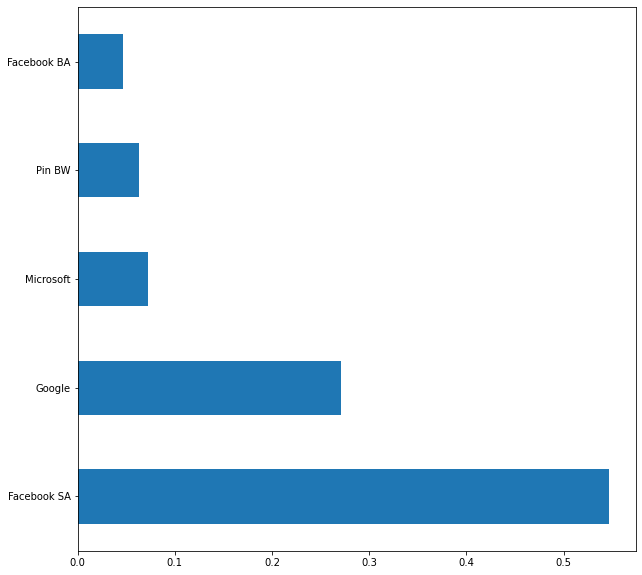

In [49]:
df_fi = df_2021.drop(['Date','Year','Month','Year_Month','WeekNumber'], axis=1)
X = df_fi.loc[:, df_fi.columns != 'Revenue']
y = df_fi['Revenue']
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

In [50]:
df[["Facebook SA","Facebook BA","Google","Pin BW","Microsoft"]].agg(['sum'])

,Facebook SA,Facebook BA,Google,Pin BW,Microsoft
sum,378610.9,388069.22,3261812.71,186878.468162,150965.09


In [86]:
df[['Revenue','Year',"Facebook SA","Facebook BA","Google","Pin BW","Microsoft"]].groupby('Year').agg(['sum'])

,Revenue,Facebook SA,Facebook BA,Google,Pin BW,Microsoft
,sum,sum,sum,sum,sum,sum
Year,,,,,,
2015,1647506.63,0.00,0.00,82778.40,0.000000,0.00
2016,2161521.90,0.00,0.00,204300.06,0.000000,0.00
2017,2482686.19,0.00,0.00,241529.19,0.000000,0.00
2018,2606465.41,0.00,0.00,243798.12,0.000000,0.00
2019,3413828.32,3151.41,12530.85,324130.97,0.000000,10773.37
2020,9982350.06,82502.67,186981.34,479160.32,2467.554672,32476.87
2021,16969661.51,241550.61,121956.41,1126437.98,135643.556247,59333.62
2022,4646098.39,51406.21,66600.62,559677.67,48767.357243,48381.23


Google has received by far the most ivestment (3.26 million pounds), followed by Facebook BA, SA, Pin BW and then Microsoft. 
Despite this skewed investment pattern, the Random Forest Feature Importance model shows that Facebook SA is the most important feature, followed by Google. 
Microsoft, Pin and Facebook BA were all around the same level. 


### Normality Tets

In [52]:
from scipy.stats import normaltest
for column in ["Facebook BA","Facebook SA","Google","Microsoft", "Pin BW","Revenue"]:
    print("{}: {}".format(column, normaltest(df_2021[column])))

Facebook BA: NormaltestResult(statistic=60.684590540438755, pvalue=6.645208254453786e-14)
Facebook SA: NormaltestResult(statistic=33.909705015274106, pvalue=4.331128953472435e-08)
Google: NormaltestResult(statistic=98.45379777134357, pvalue=4.1785870379661462e-22)
Microsoft: NormaltestResult(statistic=170.5911191537431, pvalue=9.049178289979169e-38)
Pin BW: NormaltestResult(statistic=84.47887881782155, pvalue=4.525270516315291e-19)
Revenue: NormaltestResult(statistic=59.06986468252856, pvalue=1.4898476518635155e-13)


### Regression Fit 

In [53]:
df_2021 = df_2021.rename(columns={
    "Facebook BA":'FacebookBA', 'Facebook SA':'FacebookSA', 'Pin BW': "PinBW"
})

### Daily Regressions

In [54]:
lm_day_model = sm.ols(formula="Revenue~FacebookBA+"
                          "FacebookSA+"
                          "PinBW+"
                          "Google+"
                          "Microsoft", data=df_2021).fit()
print(lm_day_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     200.8
Date:                Wed, 20 Jul 2022   Prob (F-statistic):          1.12e-101
Time:                        11:56:35   Log-Likelihood:                -3929.2
No. Observations:                 365   AIC:                             7870.
Df Residuals:                     359   BIC:                             7894.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.497e+04   3790.708      3.949      0.0

### Multicollinearity Test

VIF and multicollinearity->https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

In [55]:
y, X = dmatrices("Revenue~FacebookBA+FacebookSA+PinBW+Google+Microsoft", df_2021.rename(columns={
        "Facebook BA":'FacebookBA', 'Facebook SA':'FacebookSA', 'Pin BW': "PinBW"
}), return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,39.321748,Intercept
1,1.146241,FacebookBA
2,1.734936,FacebookSA
3,1.054169,PinBW
4,1.825708,Google
5,1.558182,Microsoft


VIF starts at 1 and has no upper limit VIF = 1, no correlation between the independent variable and the other variables VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

### Predictions for the Daily Model

2021 Predictions:

In [56]:
predictions_daily = pd.DataFrame({
    'Predictions':lm_day_model.predict(df_2021[['FacebookBA','FacebookSA','PinBW','Google','Microsoft']]),
    'Revenue': df_2021['Revenue'],
    'Date': df_2021['Date']
})
predictions_daily['ErrorAbs'] = abs(predictions_daily['Predictions'] - predictions_daily['Revenue'])
predictions_daily= predictions_daily.set_index('Date')
predictions_daily.head()

,Predictions,Revenue,ErrorAbs
Date,,,
2021-01-01,65341.207015,82921.55,17580.342985
2021-01-02,74645.811183,60075.61,14570.201183
2021-01-03,71508.748619,56313.61,15195.138619
2021-01-04,54823.655276,49477.05,5346.605276
2021-01-05,51040.069902,47978.61,3061.459902


MAE and MAPE for Daily Predictions

In [57]:
mse(predictions_daily['Predictions'], predictions_daily['Revenue'])

131190494.55135688

In [58]:
mape(predictions_daily['Predictions'], predictions_daily['Revenue'])

0.21463962702699863

In [59]:
np.mean(predictions_daily['ErrorAbs'])

8826.468973005172

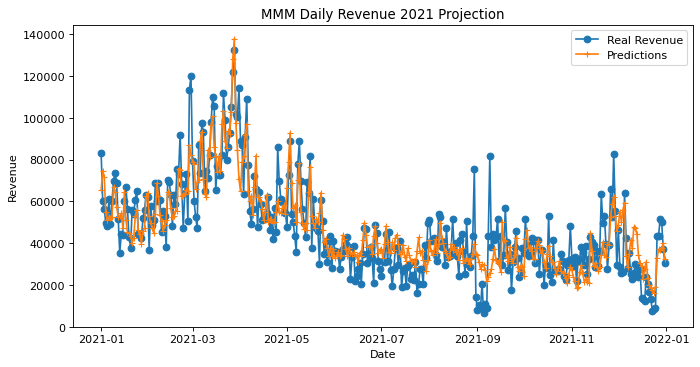

In [60]:
figure(figsize=(10, 5), dpi=80)
plt.plot(predictions_daily["Revenue"], marker='o')
plt.plot(predictions_daily["Predictions"], marker='+')

# Labelling
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("MMM Daily Revenue 2021 Projection")
plt.legend(['Real Revenue', 'Predictions'])
# Display

plt.show()

2022:

In [61]:
df_2022=df[df['Year']==2022].rename(columns={
   "Facebook BA":'FacebookBA', 'Facebook SA':'FacebookSA', 'Pin BW': "PinBW"
}).reset_index(drop=True)
predictions_daily = pd.DataFrame({
    'Predictions':lm_day_model.predict(df_2022[['FacebookBA','FacebookSA','PinBW','Google','Microsoft']]),
    'Revenue': df_2022['Revenue'],
    'Date': df_2022['Date']
})
predictions_daily['ErrorAbs'] = abs(predictions_daily['Predictions'] - predictions_daily['Revenue'])
predictions_daily= predictions_daily.set_index('Date')
predictions_daily.head()

,Predictions,Revenue,ErrorAbs
Date,,,
2022-01-01,47464.627597,32271.54,15193.087597
2022-01-02,58590.628204,73789.41,15198.781796
2022-01-03,57629.945234,61028.44,3398.494766
2022-01-04,44055.446772,39671.79,4383.656772
2022-01-05,44661.405506,30045.22,14616.185506


In [62]:
predictions_daily.to_csv('A_Daily_2022_predvact.csv')

In [63]:
mse(predictions_daily['Predictions'], predictions_daily['Revenue'])

269984463.4466691

In [64]:
mape(predictions_daily['Predictions'], predictions_daily['Revenue'])

0.4447303151928267

In [65]:
np.mean(predictions_daily['ErrorAbs'])

13958.313448847783

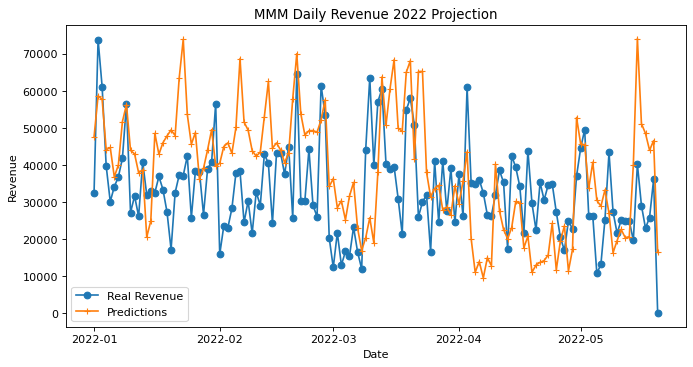

In [66]:
figure(figsize=(10, 5), dpi=80)
plt.plot(predictions_daily["Revenue"], marker='o')
plt.plot(predictions_daily["Predictions"], marker='+')

# Labelling
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("MMM Daily Revenue 2022 Projection")
plt.legend(['Real Revenue', 'Predictions'])

# Display
plt.show()

### Predictions for the Weekly Model

Transforming 2021 data to be Weekly:

In [67]:
df_2021_week=df_2021[['Revenue', 'FacebookBA','FacebookSA','PinBW','Google','Microsoft', 'WeekNumber']]
df_2021_week=df_2021_week[df_2021_week['WeekNumber'] < 52].groupby('WeekNumber').agg([sum])
df_2021_week =  df_2021_week[['Revenue', 'FacebookBA','FacebookSA','PinBW','Google','Microsoft']].reset_index(drop=True).T.reset_index(drop=True).T.rename(columns={
    0: 'Revenue',
    1: 'FacebookBA',
    2: 'FacebookSA',
    3: 'PinBW',
    4: 'Google',
    5: 'Microsoft',
})
df_2021_week['WeekNumber']=df_2021[df_2021['WeekNumber'] < 52].groupby('WeekNumber').count().reset_index()['WeekNumber']
df_2021_week.tail()

,Revenue,FacebookBA,FacebookSA,PinBW,Google,Microsoft,WeekNumber
46,360193.41,1188.61,2201.77,3718.188014,28284.07,1387.85,47
47,275028.98,2297.38,2571.77,3210.860889,31544.68,1021.66,48
48,209791.32,1952.58,1486.15,2919.837385,35812.88,3611.94,49
49,143477.52,2133.49,1873.36,3139.687874,29803.69,3659.35,50
50,118815.53,2136.66,1864.16,2831.473799,21242.19,3537.94,51


2022 Data

In [68]:
df_2022_week=df_2022[['Revenue', 'FacebookBA','FacebookSA','PinBW','Google','Microsoft', 'WeekNumber']]
df_2022_week=df_2022_week[df_2022_week['WeekNumber'] < 52].groupby('WeekNumber').agg([sum])
df_2022_week =  df_2022_week[['Revenue', 'FacebookBA','FacebookSA','PinBW','Google','Microsoft']].reset_index(drop=True).T.reset_index(drop=True).T.rename(columns={
    0: 'Revenue',
    1: 'FacebookBA',
    2: 'FacebookSA',
    3: 'PinBW',
    4: 'Google',
    5: 'Microsoft'
})
df_2022_week['WeekNumber']=df_2022[df_2022['WeekNumber'] < 52].groupby('WeekNumber').count().reset_index()['WeekNumber']
df_2022_week.head()

,Revenue,FacebookBA,FacebookSA,PinBW,Google,Microsoft,WeekNumber
0,299797.08,2130.44,2169.56,3419.610575,32875.79,1914.89,1
1,222872.89,2136.93,2168.55,3641.440180,23180.93,1507.94,2
2,221343.25,2136.50,2171.22,3432.681367,32360.87,902.44,3
3,250742.93,2135.39,2169.42,4033.711087,32357.33,2022.12,4
4,223140.41,2136.42,2171.94,4130.344042,34051.69,1994.14,5


Fitting the model

In [69]:
lm_week_model = sm.ols(formula="Revenue~FacebookBA+"
                          "FacebookSA+"
                          "PinBW+"
                          "Google+"
                          "Microsoft", data=df_2021_week).fit()
print(lm_week_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     84.96
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           9.05e-22
Time:                        11:56:43   Log-Likelihood:                -614.25
No. Observations:                  51   AIC:                             1240.
Df Residuals:                      45   BIC:                             1252.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.371e+05   4.81e+04      2.850      0.0

### Multicollinearity Test

In [70]:
y, X = dmatrices("Revenue~FacebookBA+FacebookSA+PinBW+Google+Microsoft", df_2021_week, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,61.494710,Intercept
1,1.228323,FacebookBA
2,2.138335,FacebookSA
3,1.103752,PinBW
4,2.265970,Google
5,1.667579,Microsoft


2021:

In [71]:
predictions_weekly = pd.DataFrame({
    'Predictions':lm_week_model.predict(df_2021_week[['FacebookBA','FacebookSA','PinBW','Google','Microsoft']]),
    'Revenue': df_2021_week['Revenue'],
    'WeekNumber': df_2021_week['WeekNumber']
})
predictions_weekly['ErrorAbs'] = abs(predictions_weekly['Predictions'] - predictions_weekly['Revenue'])
predictions_weekly.head()

,Predictions,Revenue,WeekNumber,ErrorAbs
0,399268.737382,411131.38,1,11862.642618
1,384071.176665,371195.14,2,12876.036665
2,331445.468162,372675.55,3,41230.081838
3,361258.181504,363654.21,4,2396.028496
4,392822.132943,392223.40,5,598.732943


In [72]:
mse(predictions_weekly['Predictions'], predictions_weekly['Revenue'])

1693733980.137973

In [73]:
mape(predictions_weekly['Predictions'], predictions_weekly['Revenue'])


0.12090634391303585

In [74]:
np.mean(predictions_weekly['ErrorAbs'])

33312.13895736347

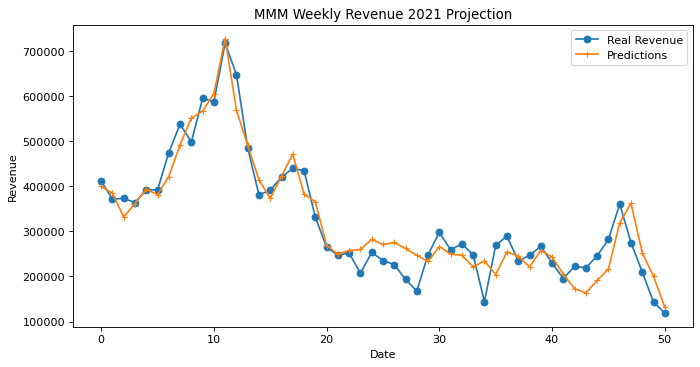

In [75]:
figure(figsize=(10, 5), dpi=80)
plt.plot(predictions_weekly["Revenue"], marker='o')
plt.plot(predictions_weekly["Predictions"], marker='+')

# Labelling
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("MMM Weekly Revenue 2021 Projection")
plt.legend(['Real Revenue', 'Predictions'])
# Display

plt.show()

2022 Predictions 

In [76]:
predictions_weekly = pd.DataFrame({
    'Predictions':lm_week_model.predict(df_2022_week[['FacebookBA','FacebookSA','PinBW','Google','Microsoft']]),
    'Revenue': df_2022_week['Revenue'],
    'WeekNumber': df_2022_week['WeekNumber']
})
predictions_weekly['ErrorAbs'] = abs(predictions_weekly['Predictions'] - predictions_weekly['Revenue'])
predictions_weekly.head()

,Predictions,Revenue,WeekNumber,ErrorAbs
0,319697.214879,299797.08,1,19900.134879
1,249281.575905,222872.89,2,26408.685905
2,365334.750888,221343.25,3,143991.500888
3,302706.168944,250742.93,4,51963.238944
4,318473.111627,223140.41,5,95332.701627


In [77]:
predictions_weekly.to_csv('A_Weekly_2022_predvact.csv')

In [78]:
mse(predictions_weekly['Predictions'], predictions_weekly['Revenue'])

7528981869.683287

In [79]:
mape(predictions_weekly['Predictions'], predictions_weekly['Revenue'])


0.4054442986203009

In [80]:
np.mean(predictions_weekly['ErrorAbs'])

75928.61977468364

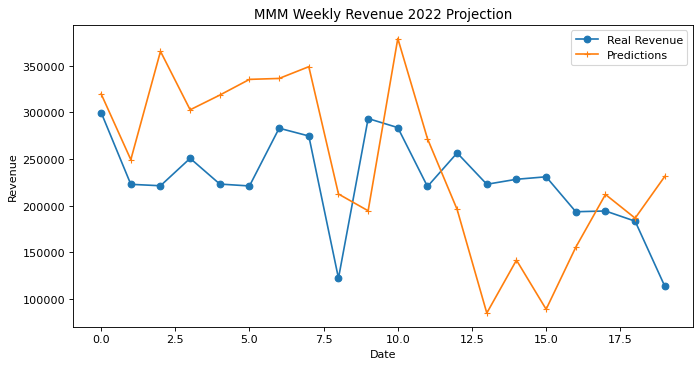

In [81]:
figure(figsize=(10, 5), dpi=80)
plt.plot(predictions_weekly["Revenue"], marker='o')
plt.plot(predictions_weekly["Predictions"], marker='+')

# Labelling
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("MMM Weekly Revenue 2022 Projection")
plt.legend(['Real Revenue', 'Predictions'])
# Display

plt.show()

### Log Log Modelling 

In [82]:
def transform_log(x):
    if x == 0:
        x += 0.000001
    return math.log(x)

df_2021_log = df_2021_week.rename(columns={
            "Facebook BA":'FacebookBA', 'Facebook SA':'FacebookSA', 'Pin BW': "PinBW"

})
for column in ['FacebookBA','FacebookSA','PinBW','Google','Microsoft',"Revenue"]:
    df_2021_log['{}Log'.format(column)] = df_2021_log[column].apply(lambda x: transform_log(x))

In [83]:
log_model = sm.ols(formula="RevenueLog~FacebookBALog+FacebookSALog+PinBWLog+GoogleLog+MicrosoftLog", data=df_2021_log).fit()
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:             RevenueLog   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     31.96
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           9.50e-14
Time:                        11:56:47   Log-Likelihood:                 13.656
No. Observations:                  51   AIC:                            -15.31
Df Residuals:                      45   BIC:                            -3.720
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.5013      1.507      4.313

### Multicollinearity Test

In [84]:
y, X = dmatrices("RevenueLog~FacebookBALog+FacebookSALog+PinBWLog+GoogleLog+MicrosoftLog", df_2021_log, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,2982.930957,Intercept
1,1.139693,FacebookBALog
2,1.631647,FacebookSALog
3,1.098552,PinBWLog
4,2.357068,GoogleLog
5,2.077474,MicrosoftLog
